Parse lentiMPRA data into format for modeling.

Add the replicate-level standard deviation (aleatoric uncertainty) to this file, thereby removing samples with no standard deviation measurement.

[Data source](https://www.biorxiv.org/content/10.1101/2023.03.05.531189v1.supplementary-material)
- Sequences: Supplementary Table 3
- Target values: Supplementary Table 4 (summary level data, mean column)

In [1]:
import h5py 
import pandas as pd
import numpy as np
np.random.seed(1234)

In [4]:
data_dir="../data/lentiMPRA"

# HepG2
## Load sequence data

In [5]:
celltype='HepG2'

In [6]:
seqs = pd.read_csv(f'{data_dir}/{celltype}_seqs.csv')

In [7]:
seqs.head()

,name,category,chr.hg19,start.hg19,stop.hg19,str.hg19,chr.hg38,start.hg38,stop.hg38,str.hg38,230nt sequence (15nt 5' adaptor - 200nt element - 15nt 3' adaptor)
0,DNasePeakNoPromoter1,putative enhancer,chr1,10410.0,10610.0,+,chr1,10410.0,10610.0,+,AGGACCGGATCAACTCCTAACCCTAACCCTAACCCTAACCCTAACC...
1,DNasePeakNoPromoter1_Reversed,putative enhancer,chr1,10410.0,10610.0,-,chr1,10410.0,10610.0,-,AGGACCGGATCAACTCGTTCTCCTCAGCACAGACCCGGAGAGCACC...
2,DNasePeakNoPromoter10,putative enhancer,chr1,941910.0,942110.0,+,chr1,1006530.0,1006730.0,+,AGGACCGGATCAACTTGTTTCTTAGGAAAGGCGGCCAACCCAGGGT...
3,DNasePeakNoPromoter10_Reversed,putative enhancer,chr1,941910.0,942110.0,-,chr1,1006530.0,1006730.0,-,AGGACCGGATCAACTGGTTAGAGCTCAAAGGTCACTCCGATGACAC...
4,DNasePeakNoPromoter100,putative enhancer,chr1,3135950.0,3136150.0,+,chr1,3219386.0,3219586.0,+,AGGACCGGATCAACTATTACTCACACAAGACACACATTGTCTGCCG...


## Load activity data

In [8]:
activity = pd.read_csv(f'{data_dir}/{celltype}_data.csv')

In [9]:
activity.head()

,name,replicate 1 [log2(rna/dna)],replicate 2 [log2(rna/dna)],replicate 3 [log2(rna/dna)],mean,std
0,DNasePeakNoPromoter37009,-0.382,-0.717,-0.816,-0.638,0.227443
1,DNasePeakNoPromoter48063,-0.562,-0.421,-0.628,-0.537,0.105740
2,DNasePeakNoPromoter48864_Reversed,-0.922,-1.122,-1.023,-1.022,0.100002
3,DNasePeakNoPromoter47281_Reversed,-0.699,-0.742,-0.754,-0.732,0.028919
4,DNasePeakNoPromoter51319,-1.051,-0.931,-0.933,-0.972,0.068712


In [12]:
activity.shape

(139885, 6)

Filter activity data for samples where std is not NA

In [13]:
activity = activity[~activity['std'].isna()]

In [14]:
activity.shape

(139407, 6)

Check to see if all sequences in activity data have a corresponding sequence.

In [15]:
activity['name'].isin(seqs['name']).all()

False

In [16]:
np.where(~activity['name'].isin(seqs['name']))

(array([ 11657,  27645,  56147,  61862,  73984,  78685,  88118, 129778]),)

In [17]:
activity.iloc[np.where(~activity['name'].isin(seqs['name']))[0],:]

,name,replicate 1 [log2(rna/dna)],replicate 2 [log2(rna/dna)],replicate 3 [log2(rna/dna)],mean,std
11663,Cneg1_hg19chr3197439136-197439306__chr31974391...,0.166,-0.275,-0.196,-0.102,0.235147
27666,Cpos2_hg19chr1935531984-35532154__chr193553198...,1.487,1.484,1.509,1.493,0.013650
56190,Cpos1_mm9chr729161576-29161746__mm9chr19355319...,-1.473,-0.904,-0.837,-1.071,0.349463
61907,Cpos1_mm9chr729161576-29161746__mm9chr19355319...,-1.302,-1.447,-1.272,-1.341,0.093586
74031,Cneg2_hg19chr5172177153-172177323__chr51721771...,-0.918,-1.107,-0.815,-0.947,0.148096
78734,Cneg1_hg19chr3197439136-197439306__chr31974391...,-0.062,-0.221,-0.092,-0.125,0.084481
88170,Cpos2_hg19chr1935531984-35532154__chr193553198...,1.139,1.085,0.655,0.960,0.265227
129850,Cneg2_hg19chr5172177153-172177323__chr51721771...,-0.404,-0.265,-0.414,-0.361,0.083289


Throw out these values.

In [18]:
activity = activity[activity['name'].isin(seqs['name'])]

In [19]:
activity.shape

(139399, 6)

Which sequences remaining in `activity` are `_Reversed` seqs?

In [20]:
rev_seqs = activity['name'][activity['name'].str.contains('Reversed')]

In [21]:
rev_seqs.shape

(67215,)

In [22]:
rev_seqs.str.contains('_Reversed_0').sum()

153

Get their corresponding forward names

In [23]:
fwd_seqs = rev_seqs.copy()

In [29]:
# strip _Reversed_0 pattern
fwd_seqs[fwd_seqs.str.contains('_Reversed_0')] = fwd_seqs[fwd_seqs.str.contains('_Reversed_0')].str.strip('_Reversed_0')
# strip _Reversed pattern
fwd_seqs[fwd_seqs.str.contains('_Reversed')] = fwd_seqs[fwd_seqs.str.contains('_Reversed')].str.strip('_Reversed')

In [30]:
fwd_seqs.shape

(67215,)

In [31]:
# sanity check
fwd_seqs.duplicated().any()

False

Are all of these in `activity`?

In [27]:
fwd_seqs.isin(activity['name']).all()

False

How many of the reversed seqs don't have their complementary fwd strand in the `activity` dataframe?

In [28]:
(~fwd_seqs.isin(activity['name'])).sum()

5962

Record the complementary fwd seqs with activity data.

In [32]:
comp_fwd_seqs = fwd_seqs[fwd_seqs.isin(activity['name'])]
comp_fwd_seqs.shape

(61253,)

In [33]:
comp_fwd_seqs.duplicated().any()

False

Which of the seqs in `rev_seqs` have a complementary fwd seq with activity data?

In [34]:
rev_seqs_with_fwd = rev_seqs[fwd_seqs.isin(comp_fwd_seqs)]

In [35]:
# sanity checks
assert(rev_seqs_with_fwd.str.strip('_Reversed').isin(comp_fwd_seqs).all())
assert(rev_seqs_with_fwd.shape[0] == comp_fwd_seqs.shape[0])

Create a mapper for fwd/rev seqs with activity data.

In [36]:
fwd_rev_dict = dict(zip(comp_fwd_seqs, rev_seqs_with_fwd))

What are the remaining sequences that aren't part of a fwd/rev pair? 

In [37]:
# expected amount
activity.shape[0] - rev_seqs_with_fwd.shape[0] - comp_fwd_seqs.shape[0]

16893

In [38]:
# get logical mask for selecting remaining seqs
mask = (~activity['name'].isin(comp_fwd_seqs)) & (~activity['name'].isin(rev_seqs_with_fwd))

In [39]:
# sanity check
assert(mask.sum()==activity.shape[0] - rev_seqs_with_fwd.shape[0] - comp_fwd_seqs.shape[0])

In [40]:
# filter seqs
other_seqs = activity['name'][mask]

In [41]:
# sanity checks
assert(other_seqs.isin(activity['name']).all())
assert((other_seqs.shape[0] + rev_seqs_with_fwd.shape[0] + comp_fwd_seqs.shape[0]) == activity.shape[0])

Summarise the data visually

<Axes: >

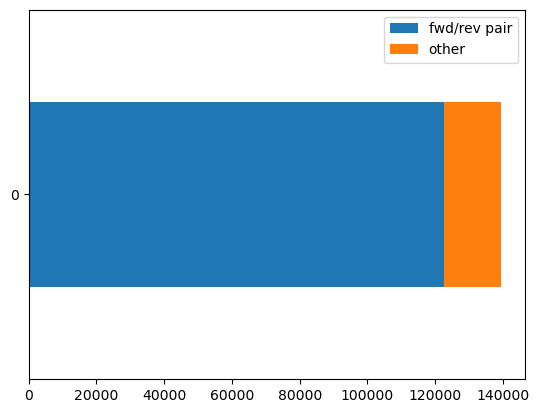

In [42]:
pd.DataFrame.from_dict({'fwd/rev pair':comp_fwd_seqs.shape[0]*2, 'other':other_seqs.shape[0]},
                       orient='index').T.plot.barh(stacked=True, legend=True)

Turn `seqs` into a dict that maps the name to the sequence.

In [43]:
seq_mapper = dict(zip(seqs['name'], seqs.iloc[:,-1]))

Create a dict that maps seqnames to mean and std of activity

In [46]:
activity_mapper = dict(zip(activity['name'], activity['mean']))
std_mapper = dict(zip(activity['name'], activity['std']))

# sanity check
assert(len(activity_mapper.keys())==len(std_mapper.keys()))
assert(activity_mapper.keys()==std_mapper.keys())

Code for one hot encoding sequences (will save one-hot encoded seqs in h5 file)

In [47]:
# define a dictionary to map nucleotides to their one-hot encoded representation
nucleotide_dict = {'A': [1.0, 0, 0, 0],
                   'C': [0, 1.0, 0, 0],
                   'G': [0, 0, 1.0, 0],
                   'T': [0, 0, 0, 1.0],
                   'N': [0, 0, 0, 0]} # sometimes there are Ns

# write function for one hot encoding a DNA sequence
def one_hot_encode(seq):
    return [nucleotide_dict[base] for base in seq]

## Come up with train/test/val splits
80/10/10

### Train

In [48]:
# get fwd/rev pairs in train set
train_fwd_seqnames_ix = np.random.choice(np.arange(comp_fwd_seqs.shape[0]), round(comp_fwd_seqs.shape[0]*0.8), replace=False)
train_fwd_seqnames = comp_fwd_seqs.iloc[train_fwd_seqnames_ix].tolist()
train_rev_seqnames = [fwd_rev_dict[x] for x in train_fwd_seqnames]

In [49]:
# get other seqs in train set
train_other_seqnames_ix = np.random.choice(np.arange(other_seqs.shape[0]), round(other_seqs.shape[0]*0.8), replace=False)
train_other_seqnames = other_seqs.iloc[train_other_seqnames_ix].tolist()

In [50]:
# total train seqs
len(train_rev_seqnames) + len(train_fwd_seqnames) + len(train_other_seqnames)

111518

In [51]:
# combine all train seqnames into a list
all_train_seqnames = train_fwd_seqnames + train_rev_seqnames + train_other_seqnames

Get numpy arrays representing `X_train` and `y_train`

In [52]:
X_train = np.array([one_hot_encode(seq_mapper[x]) for x in all_train_seqnames])

In [62]:
y_train = np.array([[activity_mapper[x], std_mapper[x]] for x in all_train_seqnames])
y_train

array([[ 0.599     ,  0.14105791],
       [-0.774     ,  0.13159027],
       [-1.17      ,  0.25512938],
       ...,
       [ 0.04      ,  0.0971099 ],
       [ 0.171     ,  0.07800214],
       [ 0.793     ,  0.1303572 ]])

### Test

In [63]:
# ix to pick from
test_fwd_options = np.setdiff1d(np.arange(comp_fwd_seqs.shape[0]), train_fwd_seqnames_ix)

In [64]:
test_fwd_seqnames_ix = np.random.choice(test_fwd_options, round(comp_fwd_seqs.shape[0]*0.1), replace=False)
test_fwd_seqnames = comp_fwd_seqs.iloc[test_fwd_seqnames_ix].tolist()
test_rev_seqnames = [fwd_rev_dict[x] for x in test_fwd_seqnames]

In [65]:
# ix to pick from
test_other_options = np.setdiff1d(np.arange(other_seqs.shape[0]), train_other_seqnames_ix)

In [66]:
# get other seqs in test set
test_other_seqnames_ix = np.random.choice(test_other_options, round(other_seqs.shape[0]*0.1), replace=False)
test_other_seqnames = other_seqs.iloc[test_other_seqnames_ix].tolist()

In [67]:
# combine all test seqnames in a list
all_test_seqnames = test_fwd_seqnames + test_rev_seqnames + test_other_seqnames

# how many seqs total?
len(all_test_seqnames)

13939

Get numpy arrays representing `X_test` and `y_test`

In [69]:
X_test = np.array([one_hot_encode(seq_mapper[x]) for x in all_test_seqnames])
y_test = np.array([[activity_mapper[x], std_mapper[x]] for x in all_test_seqnames])

### Val

In [70]:
# pick fwd/rev seqs
val_fwd_seqnames_ix = np.setdiff1d(test_fwd_options, test_fwd_seqnames_ix)
val_fwd_seqnames = comp_fwd_seqs.iloc[val_fwd_seqnames_ix].tolist()
val_rev_seqnames = [fwd_rev_dict[x] for x in val_fwd_seqnames]

In [71]:
# pick other seqs 
val_other_seqnames_ix = np.setdiff1d(test_other_options, test_other_seqnames_ix)
val_other_seqnames = other_seqs.iloc[val_other_seqnames_ix].tolist()

In [72]:
# combine all val seqnames in a list
all_val_seqnames = val_fwd_seqnames + val_rev_seqnames + val_other_seqnames

# how many seqs total?
len(all_val_seqnames)

13942

In [73]:
# sanity check - make sure all seqs in activity dataframe are accounted for
len(set(all_val_seqnames + all_test_seqnames + all_train_seqnames)) == activity.shape[0]

True

Get numpy arrays for `X_val` and `y_val`

In [74]:
X_val = np.array([one_hot_encode(seq_mapper[x]) for x in all_val_seqnames])
y_val = np.array([[activity_mapper[x], std_mapper[x]] for x in all_val_seqnames])

## Write data to h5 file

In [81]:
with h5py.File(f"{data_dir}/{celltype}_data_with_aleatoric.h5", 'w') as file:
    # train
    train = file.create_group("Train")
    train.create_dataset('X', data=X_train)
    train.create_dataset('y', data=y_train)

    # test 
    test = file.create_group('Test')
    test.create_dataset('X', data=X_test)
    test.create_dataset('y', data=y_test)

    # val
    val = file.create_group('Val')
    val.create_dataset('X', data = X_val)
    val.create_dataset('y', data=y_val)


# K562

In [89]:
celltype='K562'

## Load sequence data

In [90]:
seqs = pd.read_csv(f'{data_dir}/{celltype}_seqs.csv')

In [91]:
seqs.head()

,name,category,chr.hg38,start.hg38,stop.hg38,str.hg38,230nt sequence (15nt 5' adaptor - 200nt element - 15nt 3' adaptor)
0,peak1,putative enhancer,chr1,115631.0,115831.0,+,AGGACCGGATCAACTGAGCCGGGTCATGAAAAAGGGGATCTTGTGT...
1,peak1_Reversed,putative enhancer,chr1,115631.0,115831.0,-,AGGACCGGATCAACTTCTTGTGAGGGTGGCTTATCTGAAATGCTGC...
2,peak10,putative enhancer,chr1,634309.0,634509.0,+,AGGACCGGATCAACTTGTCGCCTTAATCCAAGCCTACGTTTTTACA...
3,peak10_Reversed,putative enhancer,chr1,634309.0,634509.0,-,AGGACCGGATCAACTAGTATGAGGAGGGTTGTGGAGTGGAAGTGAA...
4,peak100,putative enhancer,chr1,2133494.0,2133694.0,+,AGGACCGGATCAACTCCCCTCCCCAGCTGTGCGCCCGCCCCTTGGT...


In [92]:
seqs.shape

(243780, 7)

## Load activity data

In [93]:
activity = pd.read_csv(f'{data_dir}/{celltype}_data.csv')

In [94]:
activity.head()

,name,replicate 1 [log2(rna/dna)],replicate 2 [log2(rna/dna)],replicate 3 [log2(rna/dna)],mean,std
0,peak29573_Reversed,-0.190,0.225,0.201,0.079,0.232981
1,peak71109_Reversed,0.650,0.454,0.758,0.620,0.154108
2,ENSG00000123569,-0.762,-0.578,-0.228,-0.523,0.271266
3,peak25742_Reversed,-0.511,-0.644,-0.154,-0.436,0.253390
4,peak83398,-0.154,-0.298,0.103,-0.116,0.203136


In [95]:
activity.shape

(226254, 6)

Filter activity data for samples where std is not NA

In [96]:
activity = activity[~activity['std'].isna()]
activity.shape

(225705, 6)

Check to see if all sequences in activity data have a corresponding sequence.

In [97]:
activity['name'].isin(seqs['name']).all()

True

Get reverse seqs in activity dataframe.

In [98]:
rev_seqs = activity['name'][activity['name'].str.contains('Reversed')]

In [99]:
rev_seqs.shape[0]

112599

Get their corresponding forward seqnames.

In [100]:
fwd_seqs = rev_seqs.str.strip('_Reversed')

Do all of these have activity data?

In [101]:
fwd_seqs.isin(activity['name']).all()

False

Record the complementary fwd seqs with activity data.

In [102]:
comp_fwd_seqs = fwd_seqs[fwd_seqs.isin(activity['name'])]
comp_fwd_seqs.shape

(109156,)

Which of the seqs in `rev_seqs` have a complementary fwd seq with activity data?

In [103]:
rev_seqs_with_fwd = rev_seqs[fwd_seqs.isin(comp_fwd_seqs)]

In [105]:
rev_seqs_with_fwd.shape

(109156,)

In [106]:
# sanity checks
assert(rev_seqs_with_fwd.str.strip('_Reversed').isin(comp_fwd_seqs).all())
assert(rev_seqs_with_fwd.shape[0] == comp_fwd_seqs.shape[0])

Create a mapper for fwd/rev seqs with activity data.

In [107]:
fwd_rev_dict = dict(zip(comp_fwd_seqs, rev_seqs_with_fwd))

What are the remaining sequences that aren't part of a fwd/rev pair? 

In [108]:
# expected amount
activity.shape[0] - rev_seqs_with_fwd.shape[0] - comp_fwd_seqs.shape[0]

7393

In [109]:
# get logical mask for selecting remaining seqs
mask = (~activity['name'].isin(comp_fwd_seqs)) & (~activity['name'].isin(rev_seqs_with_fwd))

In [110]:
# sanity check
assert(mask.sum()==activity.shape[0] - rev_seqs_with_fwd.shape[0] - comp_fwd_seqs.shape[0])

In [111]:
# filter seqs
other_seqs = activity['name'][mask]

In [112]:
# sanity checks
assert(other_seqs.isin(activity['name']).all())
assert((other_seqs.shape[0] + rev_seqs_with_fwd.shape[0] + comp_fwd_seqs.shape[0]) == activity.shape[0])

Summarise the data visually

<Axes: >

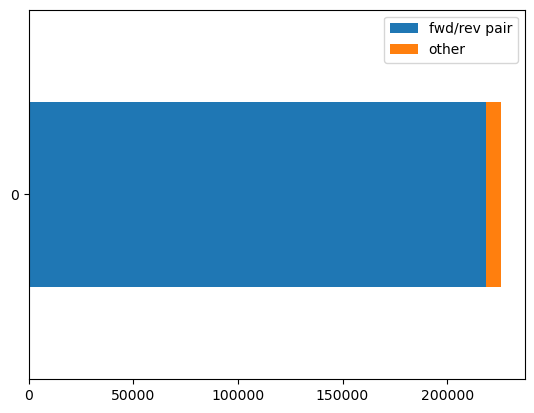

In [115]:
pd.DataFrame.from_dict({'fwd/rev pair':comp_fwd_seqs.shape[0]*2, 'other':other_seqs.shape[0]},
                       orient='index').T.plot.barh(stacked=True, legend=True)

Turn `seqs` into a dict that maps the name to the sequence.

In [116]:
seq_mapper = dict(zip(seqs['name'], seqs.iloc[:,-1]))

Create a dict that maps seqnames to mean and std. activity

In [117]:
activity_mapper = dict(zip(activity['name'], activity['mean']))
std_mapper = dict(zip(activity['name'], activity['std']))


## Come up with train/test/val splits
80/10/10

### Train

In [118]:
# get fwd/rev pairs in train set
train_fwd_seqnames_ix = np.random.choice(np.arange(comp_fwd_seqs.shape[0]), round(comp_fwd_seqs.shape[0]*0.8), replace=False)
train_fwd_seqnames = comp_fwd_seqs.iloc[train_fwd_seqnames_ix].tolist()
train_rev_seqnames = [fwd_rev_dict[x] for x in train_fwd_seqnames]

In [119]:
# get other seqs in train set
train_other_seqnames_ix = np.random.choice(np.arange(other_seqs.shape[0]), round(other_seqs.shape[0]*0.8), replace=False)
train_other_seqnames = other_seqs.iloc[train_other_seqnames_ix].tolist()

In [120]:
# total train seqs
len(train_rev_seqnames) + len(train_fwd_seqnames) + len(train_other_seqnames)

180564

In [121]:
# combine all train seqnames into a list
all_train_seqnames = train_fwd_seqnames + train_rev_seqnames + train_other_seqnames

Get numpy arrays representing `X_train` and `y_train`

In [124]:
X_train = np.array([one_hot_encode(seq_mapper[x]) for x in all_train_seqnames])
y_train = np.array([[activity_mapper[x], std_mapper[x]] for x in all_train_seqnames])

### Test

In [126]:
# ix to pick from
test_fwd_options = np.setdiff1d(np.arange(comp_fwd_seqs.shape[0]), train_fwd_seqnames_ix)

In [127]:
test_fwd_seqnames_ix = np.random.choice(test_fwd_options, round(comp_fwd_seqs.shape[0]*0.1), replace=False)
test_fwd_seqnames = comp_fwd_seqs.iloc[test_fwd_seqnames_ix].tolist()
test_rev_seqnames = [fwd_rev_dict[x] for x in test_fwd_seqnames]

In [128]:
# ix to pick from
test_other_options = np.setdiff1d(np.arange(other_seqs.shape[0]), train_other_seqnames_ix)

In [129]:
# get other seqs in test set
test_other_seqnames_ix = np.random.choice(test_other_options, round(other_seqs.shape[0]*0.1), replace=False)
test_other_seqnames = other_seqs.iloc[test_other_seqnames_ix].tolist()

In [130]:
# combine all test seqnames in a list
all_test_seqnames = test_fwd_seqnames + test_rev_seqnames + test_other_seqnames

# how many seqs total?
len(all_test_seqnames)

22571

Get numpy arrays representing `X_test` and `y_test`

In [131]:
X_test = np.array([one_hot_encode(seq_mapper[x]) for x in all_test_seqnames])
y_test = np.array([[activity_mapper[x], std_mapper[x]] for x in all_test_seqnames])

### Val

In [133]:
# pick fwd/rev seqs
val_fwd_seqnames_ix = np.setdiff1d(test_fwd_options, test_fwd_seqnames_ix)
val_fwd_seqnames = comp_fwd_seqs.iloc[val_fwd_seqnames_ix].tolist()
val_rev_seqnames = [fwd_rev_dict[x] for x in val_fwd_seqnames]

In [134]:
# pick other seqs 
val_other_seqnames_ix = np.setdiff1d(test_other_options, test_other_seqnames_ix)
val_other_seqnames = other_seqs.iloc[val_other_seqnames_ix].tolist()

In [135]:
# combine all test seqnames in a list
all_val_seqnames = val_fwd_seqnames + val_rev_seqnames + val_other_seqnames

# how many seqs total?
len(all_val_seqnames)

22570

In [136]:
# sanity check - make sure all seqs in activity dataframe are accounted for
assert(len(set(all_train_seqnames + all_test_seqnames + all_val_seqnames)) == activity.shape[0])


Get numpy arrays for `X_val` and `y_val`

In [137]:
X_val = np.array([one_hot_encode(seq_mapper[x]) for x in all_val_seqnames])
y_val = np.array([[activity_mapper[x], std_mapper[x]] for x in all_val_seqnames])

## Write data to h5 file

In [142]:
with h5py.File(f"{data_dir}/{celltype}_data_with_aleatoric.h5", 'w') as file:
    # train
    train = file.create_group("Train")
    train.create_dataset('X', data=X_train)
    train.create_dataset('y', data=y_train)

    # test 
    test = file.create_group('Test')
    test.create_dataset('X', data=X_test)
    test.create_dataset('y', data=y_test)

    # val
    val = file.create_group('Val')
    val.create_dataset('X', data = X_val)
    val.create_dataset('y', data=y_val)


# Some code for loading in the data...

In [5]:
def load_lentimpra(h5_file):
    data = h5py.File(h5_file, 'r')

    # train
    X_train = np.array(data['Train']['X'])
    y_train = np.array(data['Train']['y'])

    # test
    X_test = np.array(data['Test']['X'])
    y_test = np.array(data['Test']['y'])

    # val
    X_val = np.array(data['Val']['X'])
    y_val = np.array(data['Val']['y'])

    return X_train, y_train, X_test, y_test, X_val, y_val

In [6]:
X_train, y_train, X_test, y_test, X_val, y_val = load_lentimpra('../data/lentiMPRA/HepG2_data_with_aleatoric.h5')

In [9]:
assert(y_train.shape[-1]==2 & y_test.shape[-1]==2 & y_val.shape[-1]==2)